In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()

qiskit_runtime_service.__init__:INFO:2024-02-11 20:03:26,494: Default instance: ibm-q/open/main


In [2]:
import qiskit.tools.jupyter

%qiskit_version_table

In [3]:
# useful additional packages
import matplotlib.pyplot as plt
import numpy as np
import pylab

import networkx as nx

from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit_algorithms import SamplingVQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SPSA, COBYLA, NELDER_MEAD
from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer

from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector

from itertools import permutations #per brutal approches TSP

In [4]:
#draw a graph by coloring the nodes 
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)
    
#funzione per disegnare un cammino su un grafo 
def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(
        G2, node_color=colors, edge_color="b", node_size=600, alpha=0.8, ax=default_axes, pos=pos
    )
    edge_labels = nx.get_edge_attributes(G2, "weight")
    nx.draw_networkx_edge_labels(G2, pos, font_color="b", edge_labels=edge_labels)

### TSP 

In [5]:
counts=[]
params=[]
values=[]
mddict=[]
def store_intermediate_result(count, parameters, value, step):
    counts.append(count)
    params.append(parameters)
    values.append(value)
    mddict.append(step)
  #  nonso.append(nnso)

In [6]:
### Proviamoo a definire un grafo con 4 vertici

In [7]:
n = 4  # Number of nodes in graph
G_4 = nx.Graph()
G_4.add_nodes_from(np.arange(0, n, 1))
elist = [(0, 1, 1), (0, 2, 1), (0, 3, 3), (1, 2, 3), (1, 3, 1), (2,3,1)]
# tuple is (i,j,weight) where (i,j) is the edge
G_4.add_weighted_edges_from(elist)

colors = ["r" for node in G_4.nodes()]
pos = nx.spring_layout(G_4)

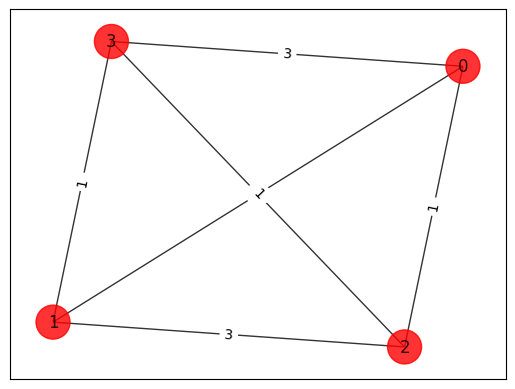

In [8]:
draw_graph(G_4, colors, pos)

In [9]:
tsp4 = Tsp(G_4)

In [10]:
adj_matrix1 = nx.to_numpy_array(tsp4.graph)

In [11]:
qp_tsp4 = tsp4.to_quadratic_program()

In [12]:
qp2qubo_tsp4 = QuadraticProgramToQubo()
qubo_tsp4 = qp2qubo_tsp4.convert(qp_tsp4)
qubitOp_tsp4, offset = qubo_tsp4.to_ising()

In [13]:
#exact eigenvalue and eigenvector
ee = NumPyMinimumEigensolver()
result_tsp_1 = ee.compute_minimum_eigenvalue(qubitOp_tsp4)

print("energy:", result_tsp_1.eigenvalue.real)
print("tsp objective:", result_tsp_1.eigenvalue.real + offset)
x_tsp = tsp4.sample_most_likely(result_tsp_1.eigenstate)
print("feasible:", qubo_tsp4.is_feasible(x_tsp))
z_tsp = tsp4.interpret(x_tsp)
print("solution:", z_tsp)
print("solution objective:", tsp4.tsp_value(z_tsp, adj_matrix1))

energy: -1312.0
tsp objective: 4.0
feasible: True
solution: [0, 1, 3, 2]
solution objective: 4.0


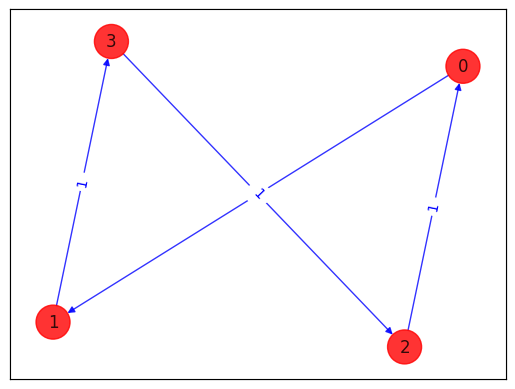

In [14]:
draw_graph(G_4, colors, pos)
draw_tsp_solution(tsp4.graph, z_tsp, colors, pos)

In [15]:
algorithm_globals.random_seed = 123
seed = 10598

Proposed 1

In [23]:
# create the Ansatz
theta = ParameterVector('theta', qubitOp_tsp4.num_qubits)
qc2 = QuantumCircuit(qubitOp_tsp4.num_qubits)
for i in range (0,qubitOp_tsp4.num_qubits, n):
    qc2.x(i)
    qc2.barrier(range(i, i+n))
    for j in range(i+1,i+n,1):
        qc2.ry(theta[j-1], j)
        qc2.cz(j-1,j)
        qc2.ry(-theta[j-1], j)
        qc2.barrier(range(i, i+n))
    for j in range(i+1,i+n,1):
        qc2.cx(j,j-1)
#qc2.draw('mpl',plot_barriers=False)

/opt/conda/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


6.420557498931885
5.14339542388916
5.610624982853128
-1226.0937446705352
-1307.953294038875
-1289.7794791521048


33

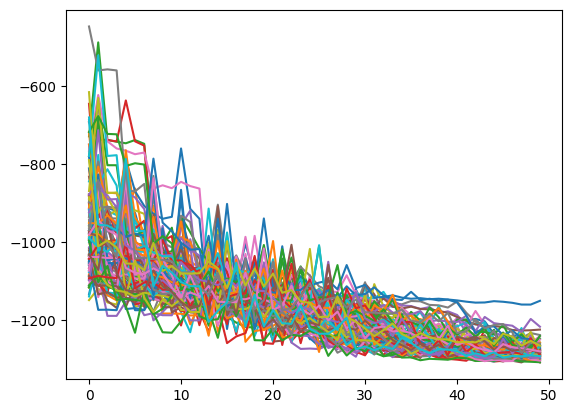

In [17]:
# construct SamplingVQE with callback
time=[]
energy=[]
solution=[]
for i in range (1,101,1):
    counts=[]
    params=[]
    values=[]
    mddict=[]
    optimizer = COBYLA(maxiter=50)
    #ry_clb  = TwoLocal(qubitOp_tsp4.num_qubits, 'rx', "cz", reps=1, entanglement="linear")
    vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=qc2, optimizer=optimizer, callback=store_intermediate_result)
    # run SamplingVQE 
    result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4) 
    pylab.plot( values)
    x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
    if qp_tsp4.is_feasible(x_clb)== True:
        z_clb = tsp4.interpret(x_clb)
        energy.append(result_clb.eigenvalue.real)
        time.append(result_clb.optimizer_time)
        solution.append(tsp4.tsp_value(z_clb, adj_matrix1))
print(max(time))
print(min(time))
print(sum(time)/len(time))
print(max(energy))
print(min(energy))
print(sum(energy)/len(energy))
sum(1 for n in solution if n == 4)

12.177330017089844
9.929970979690552
10.951783306598664
-1303.6974637837848
-1311.9689172624635
-1308.9077005940192


31

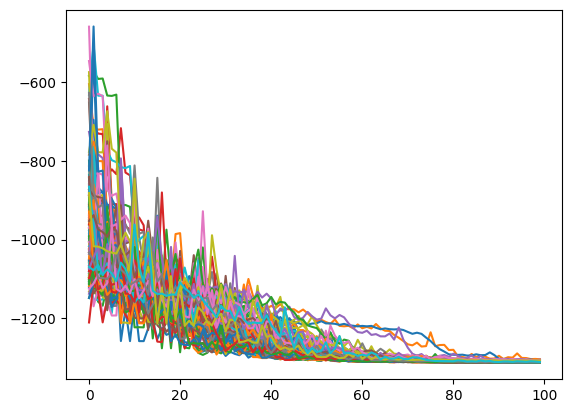

In [18]:
time=[]
energy=[]
solution=[]
for i in range (1,101,1):
    counts=[]
    params=[]
    values=[]
    mddict=[]
    optimizer = COBYLA(maxiter=100)
    vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=qc2, optimizer=optimizer, callback=store_intermediate_result)
    # run SamplingVQE 
    result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4) 
    pylab.plot( values)
    x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
    if qp_tsp4.is_feasible(x_clb)== True:
        z_clb = tsp4.interpret(x_clb)
        energy.append(result_clb.eigenvalue.real)
        time.append(result_clb.optimizer_time)
        solution.append(tsp4.tsp_value(z_clb, adj_matrix1))
print(max(time))
print(min(time))
print(sum(time)/len(time))
print(max(energy))
print(min(energy))
print(sum(energy)/len(energy))
sum(1 for n in solution if n == 4)

Proposed 2

In [17]:
# create the Ansatz
def W_circuit(QC, n, q1n, theta):
    QC.x(q1n)
    for j in range(q1n+1,q1n+n,1):
        QC.ry(theta[j-1], j)
        QC.cz(j-1,j)
        QC.ry(-theta[j-1], j)
    for j in range(q1n+1,q1n+n,1):
        QC.cx(j,j-1)

def base_circuit(QC, n, theta):
    #theta1 = ParameterVector('theta2', 1)
    QC.x(0)
    QC.ry(theta[1], 1)
    QC.cz(0,1)
    QC.ry(-theta[1], 1)
    QC.cx(1,0)
    QC.cx(1,n)
    QC.cx(0,n+1)


In [18]:
n=4
qc = QuantumCircuit(n**2)
theta = ParameterVector('theta', n**2)
base_circuit(qc,n, theta)
for i in range(3,n+1,1):
    W_circuit(qc, i, n*(i-1), theta)
for k in range (3,n+1,1):
    for v in range(1,k,1):
        for p in range(1,k,1):
            qc.cswap(n*(k-1)+v-1,n*(p-1)+n-(n-k)-1,n*(p-1)+v-1)

#qc.draw()

2.8726389408111572
1.8305995464324951
2.1535445833206177
-1311.6723299062091
-1311.9990409967847
-1311.961821552233


100

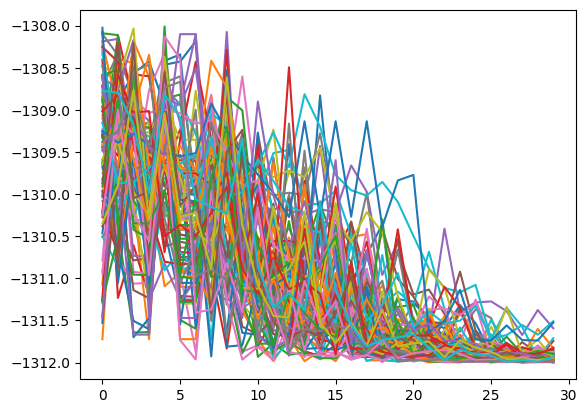

In [24]:
time=[]
energy=[]
solution=[]
for i in range (1,101,1):
    counts=[]
    params=[]
    values=[]
    mddict=[]
    optimizer = COBYLA(maxiter=30)
    vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=qc, optimizer=optimizer, callback=store_intermediate_result)
    # run SamplingVQE 
    result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4) 
    pylab.plot( values)
    x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
    if qp_tsp4.is_feasible(x_clb)== True:
        z_clb = tsp4.interpret(x_clb)
        energy.append(result_clb.eigenvalue.real)
        time.append(result_clb.optimizer_time)
        solution.append(tsp4.tsp_value(z_clb, adj_matrix1))
print(max(time))
print(min(time))
print(sum(time)/len(time))
print(max(energy))
print(min(energy))
print(sum(energy)/len(energy))
sum(1 for n in solution if n == 4)

4.442834138870239
3.2144157886505127
3.599193961620331
-1311.9934342674906
-1311.9999988842603
-1311.9990916129814


100

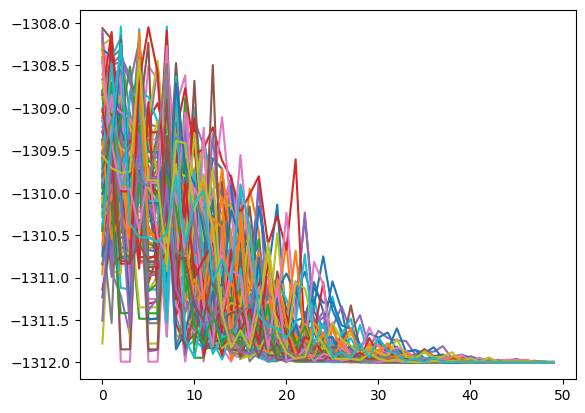

In [25]:
time=[]
energy=[]
solution=[]
for i in range (1,101,1):
    counts=[]
    params=[]
    values=[]
    mddict=[]
    optimizer = COBYLA(maxiter=50)
    vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=qc, optimizer=optimizer, callback=store_intermediate_result)
    # run SamplingVQE 
    result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4) 
    pylab.plot( values)
    x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
    if qp_tsp4.is_feasible(x_clb)== True:
        z_clb = tsp4.interpret(x_clb)
        energy.append(result_clb.eigenvalue.real)
        time.append(result_clb.optimizer_time)
        solution.append(tsp4.tsp_value(z_clb, adj_matrix1))
print(max(time))
print(min(time))
print(sum(time)/len(time))
print(max(energy))
print(min(energy))
print(sum(energy)/len(energy))
sum(1 for n in solution if n == 4)

3.6536624431610107
2.3725836277008057
2.869935290813446
-1311.9534609077705
-1311.99989594907
-1311.994574410518


100

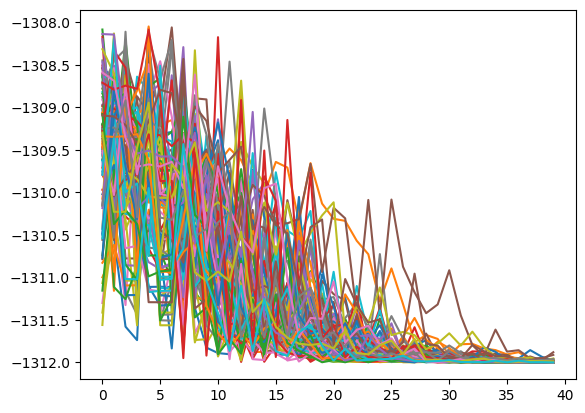

In [26]:
time=[]
energy=[]
solution=[]
for i in range (1,101,1):
    counts=[]
    params=[]
    values=[]
    mddict=[]
    optimizer = COBYLA(maxiter=40)
    vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=qc, optimizer=optimizer, callback=store_intermediate_result)
    # run SamplingVQE 
    result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4) 
    pylab.plot( values)
    x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
    if qp_tsp4.is_feasible(x_clb)== True:
        z_clb = tsp4.interpret(x_clb)
        energy.append(result_clb.eigenvalue.real)
        time.append(result_clb.optimizer_time)
        solution.append(tsp4.tsp_value(z_clb, adj_matrix1))
print(max(time))
print(min(time))
print(sum(time)/len(time))
print(max(energy))
print(min(energy))
print(sum(energy)/len(energy))
sum(1 for n in solution if n == 4)

1.3737568855285645
0.5558581352233887
0.7268009662628174
-1309.4840331954756
-1311.9079458593412
-1310.9151695102066


96

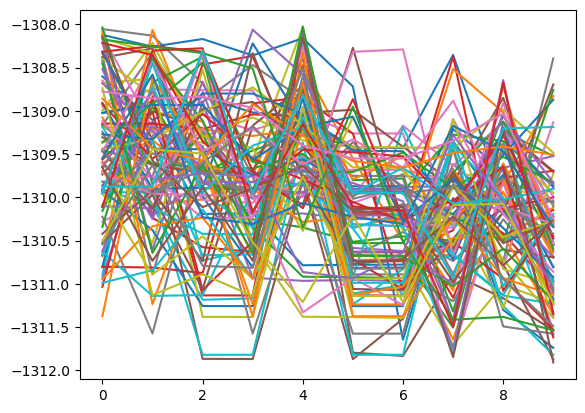

In [21]:
time=[]
energy=[]
solution=[]
for i in range (1,101,1):
    counts=[]
    params=[]
    values=[]
    mddict=[]
    optimizer = COBYLA(maxiter=10)
    vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=qc, optimizer=optimizer, callback=store_intermediate_result)
    # run SamplingVQE 
    result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4) 
    pylab.plot( values)
    x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
    if qp_tsp4.is_feasible(x_clb)== True:
        z_clb = tsp4.interpret(x_clb)
        energy.append(result_clb.eigenvalue.real)
        time.append(result_clb.optimizer_time)
        solution.append(tsp4.tsp_value(z_clb, adj_matrix1))
print(max(time))
print(min(time))
print(sum(time)/len(time))
print(max(energy))
print(min(energy))
print(sum(energy)/len(energy))
sum(1 for n in solution if n == 4)

1.510084867477417
0.8822000026702881
1.0957855319976806
-1309.752179200787
-1311.969230328176
-1311.491931322081


98

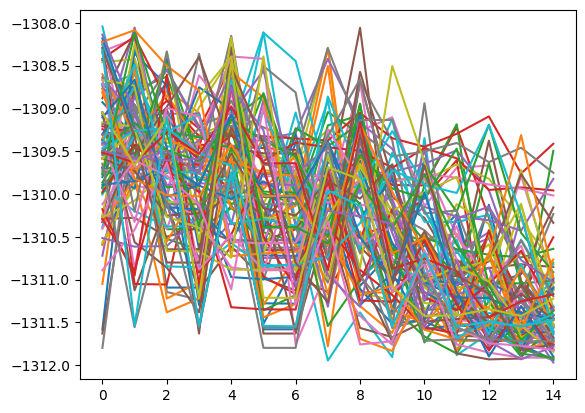

In [38]:
time=[]
energy=[]
solution=[]
for i in range (1,101,1):
    counts=[]
    params=[]
    values=[]
    mddict=[]
    optimizer = COBYLA(maxiter=15)
    vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=qc, optimizer=optimizer, callback=store_intermediate_result)
    # run SamplingVQE 
    result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4) 
    pylab.plot( values)
    x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
    if qp_tsp4.is_feasible(x_clb)== True:
        z_clb = tsp4.interpret(x_clb)
        energy.append(result_clb.eigenvalue.real)
        time.append(result_clb.optimizer_time)
        solution.append(tsp4.tsp_value(z_clb, adj_matrix1))
print(max(time))
print(min(time))
print(sum(time)/len(time))
print(max(energy))
print(min(energy))
print(sum(energy)/len(energy))
sum(1 for n in solution if n == 4)

1.7881262302398682
1.1916158199310303
1.4428549909591675
-1310.0248602492545
-1311.995787904151
-1311.7934709715034


100

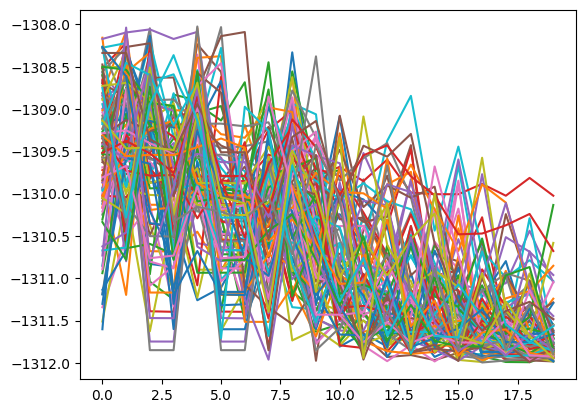

In [20]:
time=[]
energy=[]
solution=[]
for i in range (1,101,1):
    counts=[]
    params=[]
    values=[]
    mddict=[]
    optimizer = COBYLA(maxiter=20)
    vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=qc, optimizer=optimizer, callback=store_intermediate_result)
    # run SamplingVQE 
    result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4) 
    pylab.plot( values)
    x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
    if qp_tsp4.is_feasible(x_clb)== True:
        z_clb = tsp4.interpret(x_clb)
        energy.append(result_clb.eigenvalue.real)
        time.append(result_clb.optimizer_time)
        solution.append(tsp4.tsp_value(z_clb, adj_matrix1))
print(max(time))
print(min(time))
print(sum(time)/len(time))
print(max(energy))
print(min(energy))
print(sum(energy)/len(energy))
sum(1 for n in solution if n == 4)

Confronto Convergenza

In [27]:
counts=[]
params=[]
values=[]
mddict=[]
optimizer = COBYLA(maxiter=50)
vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=qc2, optimizer=optimizer, callback=store_intermediate_result)
# run SamplingVQE 
result=vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4)
print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
x= tsp4.sample_most_likely(result.eigenstate)
print("feasible:", qp_tsp4.is_feasible(x))
z = tsp4.interpret(x)
print("solution:", z)
print("solution objective:", tsp4.tsp_value(z, adj_matrix1))
values1=values
#

energy: -1304.6881107501931
time: 5.8040611743927
feasible: True
solution: [2, 3, 1, 0]
solution objective: 4.0


In [42]:
counts=[]
params=[]
values=[]
mddict=[]
optimizer = SPSA(maxiter=50)
vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=qc2, optimizer=optimizer, callback=store_intermediate_result)
# run SamplingVQE 
result=vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4)
print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
x= tsp4.sample_most_likely(result.eigenstate)
print("feasible:", qp_tsp4.is_feasible(x))
z = tsp4.interpret(x)
print("solution:", z)
print("solution objective:", tsp4.tsp_value(z, adj_matrix1))
values2=values
#

energy: -1281.185968106879
time: 16.996614456176758
feasible: True
solution: [1, 3, 2, 0]
solution objective: 4.0


In [29]:
counts=[]
params=[]
values=[]
mddict=[]
optimizer = COBYLA(maxiter=50)
vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=qc, optimizer=optimizer, callback=store_intermediate_result)
# run SamplingVQE 
result=vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4)
print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
x= tsp4.sample_most_likely(result.eigenstate)
print("feasible:", qp_tsp4.is_feasible(x))
z = tsp4.interpret(x)
print("solution:", z)
print("solution objective:", tsp4.tsp_value(z, adj_matrix1))
values3=values


energy: -1311.9985857712297
time: 3.1715762615203857
feasible: True
solution: [3, 2, 0, 1]
solution objective: 4.0


In [30]:
counts=[]
params=[]
values=[]
mddict=[]
optimizer = SPSA(maxiter=50)
vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=qc, optimizer=optimizer, callback=store_intermediate_result)
# run SamplingVQE 
result=vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4)
print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
x= tsp4.sample_most_likely(result.eigenstate)
print("feasible:", qp_tsp4.is_feasible(x))
z = tsp4.interpret(x)
print("solution:", z)
print("solution objective:", tsp4.tsp_value(z, adj_matrix1))
values4=values


energy: -1311.9999999544148
time: 9.745106935501099
feasible: True
solution: [3, 2, 0, 1]
solution objective: 4.0


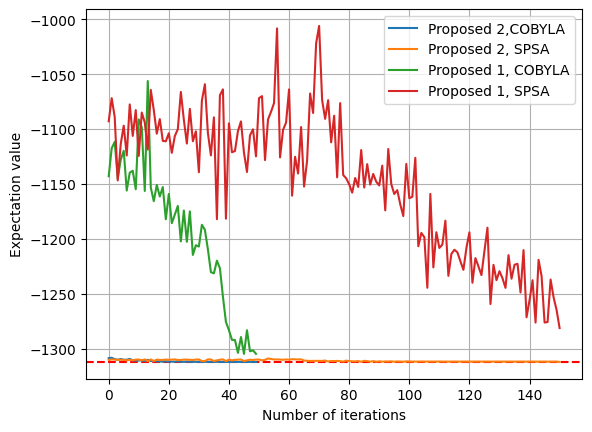

In [43]:
plt.axhline(y=-1312, color='r', linestyle='--')


pylab.plot(values3, label= f'Proposed 2,COBYLA')
pylab.plot(values4, label= f'Proposed 2, SPSA')
pylab.plot(values1, label= f'Proposed 1, COBYLA')
pylab.plot(values2, label= f'Proposed 1, SPSA')


pylab.grid(True)
plt.legend()
plt.xlabel('Number of iterations')
plt.ylabel('Expectation value')
# Mostra il grafico
pylab.show()

energy: -1311.9963072095343
time: 3.3542282581329346
feasible: True
solution: [2, 3, 1, 0]
solution objective: 4.0
energy: -1311.9987408474597
time: 10.716153383255005
feasible: True
solution: [2, 3, 1, 0]
solution objective: 4.0


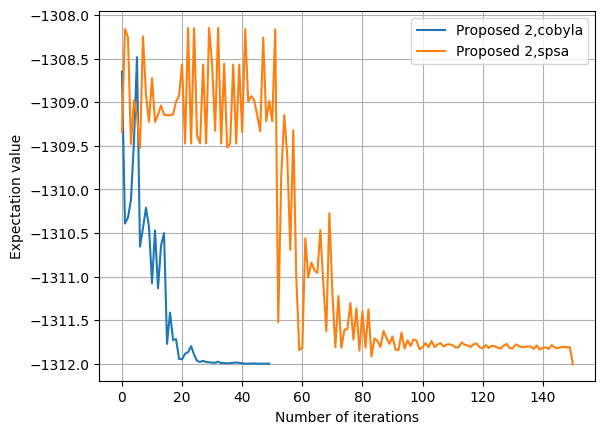

In [44]:
counts=[]
params=[]
values=[]
mddict=[]
optimizer = COBYLA(maxiter=50)
vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=qc, optimizer=optimizer, callback=store_intermediate_result)
# run SamplingVQE 
result=vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4)
print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
x= tsp4.sample_most_likely(result.eigenstate)
print("feasible:", qp_tsp4.is_feasible(x))
z = tsp4.interpret(x)
print("solution:", z)
print("solution objective:", tsp4.tsp_value(z, adj_matrix1))
pylab.plot(values, label= f'Proposed 2,cobyla')
counts=[]
params=[]
values=[]
mddict=[]
optimizer = SPSA(maxiter=50)
vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=qc, optimizer=optimizer, callback=store_intermediate_result)
# run SamplingVQE 
result=vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4)
print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
x= tsp4.sample_most_likely(result.eigenstate)
print("feasible:", qp_tsp4.is_feasible(x))
z = tsp4.interpret(x)
print("solution:", z)
print("solution objective:", tsp4.tsp_value(z, adj_matrix1))
pylab.plot(values, label= f'Proposed 2,spsa')

pylab.grid(True)
plt.legend()
plt.xlabel('Number of iterations')
plt.ylabel('Expectation value')
# Mostra il grafico
pylab.show()

energy: -1311.9267767549916
time: 1.4107551574707031
feasible: True
solution: [2, 3, 1, 0]
solution objective: 4.0
energy: -1311.9584091507982
time: 5.864179849624634
feasible: True
solution: [3, 1, 0, 2]
solution objective: 4.0


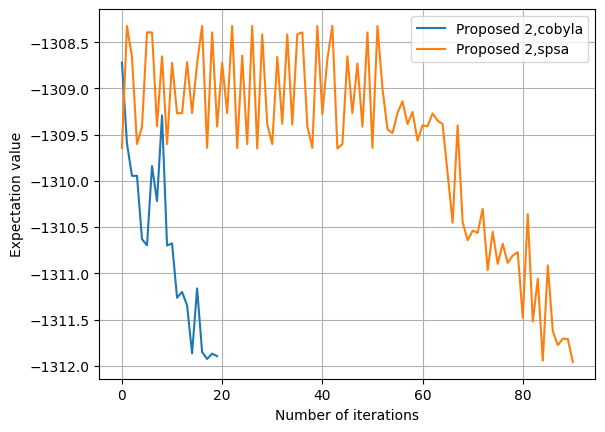

In [45]:
counts=[]
params=[]
values=[]
mddict=[]
optimizer = COBYLA(maxiter=20)
vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=qc, optimizer=optimizer, callback=store_intermediate_result)
# run SamplingVQE 
result=vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4)
print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
x= tsp4.sample_most_likely(result.eigenstate)
print("feasible:", qp_tsp4.is_feasible(x))
z = tsp4.interpret(x)
print("solution:", z)
print("solution objective:", tsp4.tsp_value(z, adj_matrix1))
pylab.plot(values, label= f'Proposed 2,cobyla')
counts=[]
params=[]
values=[]
mddict=[]
optimizer = SPSA(maxiter=20)
vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=qc, optimizer=optimizer, callback=store_intermediate_result)
# run SamplingVQE 
result=vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4)
print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
x= tsp4.sample_most_likely(result.eigenstate)
print("feasible:", qp_tsp4.is_feasible(x))
z = tsp4.interpret(x)
print("solution:", z)
print("solution objective:", tsp4.tsp_value(z, adj_matrix1))
pylab.plot(values, label= f'Proposed 2,spsa')

pylab.grid(True)
plt.legend()
plt.xlabel('Number of iterations')
plt.ylabel('Expectation value')
# Mostra il grafico
pylab.show()